In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import string
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix



In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
# --- Segment 0: Load and Combine Data ---

# Load labelled CSVs from Kaggle Reddit Mental Health dataset
ld_da = pd.read_csv('/content/drive/My Drive/Reddit/Original Reddit Data/Labelled Data/LD DA 1.csv')
ld_el = pd.read_csv('/content/drive/My Drive/Reddit/Original Reddit Data/Labelled Data/LD EL1.csv')
ld_pf = pd.read_csv('/content/drive/My Drive/Reddit/Original Reddit Data/Labelled Data/LD PF1.csv')
ld_ts = pd.read_csv('/content/drive/My Drive/Reddit/Original Reddit Data/Labelled Data/LD TS 1.csv')


In [10]:
# Combine all four datasets into one
data = pd.concat([ld_da, ld_el, ld_pf, ld_ts], ignore_index=True)


In [11]:
# --- Segment 1: Data Cleaning and Preprocessing ---

# Drop rows missing subreddit, selftext, or title to ensure complete data
data = data.dropna(subset=['subreddit', 'selftext', 'title'])


In [12]:
# Combine 'selftext' and 'title' into a single 'text' field
data['text'] = data['selftext'].fillna('') + ' ' + data['title'].fillna('')


In [13]:
# Remove posts that are too short (less than 20 characters)
data = data[data['text'].str.len() > 20]


In [14]:
# Define basic text preprocessing: lowercasing, removing punctuation, normalizing spaces
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub("\\s+", " ", text).strip()
    return text


In [15]:
# Apply preprocessing to the text data
data['text'] = data['text'].apply(preprocess_text)


In [16]:
# --- Segment 2: Define Features and Target ---

# Features (X) are the text posts, Target (y) is the subreddit label
X = data['text']
y = data['subreddit']

In [17]:
# --- Segment 3: Train-Test Split and Vectorization ---

# Split data into 80% train, 20% test, while preserving class distribution (stratify)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [18]:
# Initialize a TF-IDF Vectorizer (maximum 5000 words, removing English stop words)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

In [19]:
# Fit vectorizer on training data and transform both train and test sets
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [20]:
# --- Segment 4: Model Training ---

# Initialize Logistic Regression with balanced class weights
model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model on the training set
model.fit(X_train_vec, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [21]:
# --- Segment 5: Evaluation ---

# Predict subreddit labels for the test set
y_pred = model.predict(X_test_vec)


In [22]:
# Calculate and print overall accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.58125


In [23]:
# Generate and print detailed classification report (precision, recall, F1-score)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:\n", report_df.round(2))



Classification Report:
               precision  recall  f1-score  support
Anxiety            0.74    0.76      0.75    37.00
SuicideWatch       0.45    0.37      0.41    27.00
depression         0.53    0.64      0.58    56.00
lonely             0.71    0.50      0.59    10.00
mentalhealth       0.56    0.47      0.51    30.00
accuracy           0.58    0.58      0.58     0.58
macro avg          0.60    0.55      0.57   160.00
weighted avg       0.58    0.58      0.58   160.00


In [24]:
# --- Segment 6: Visualization ---

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

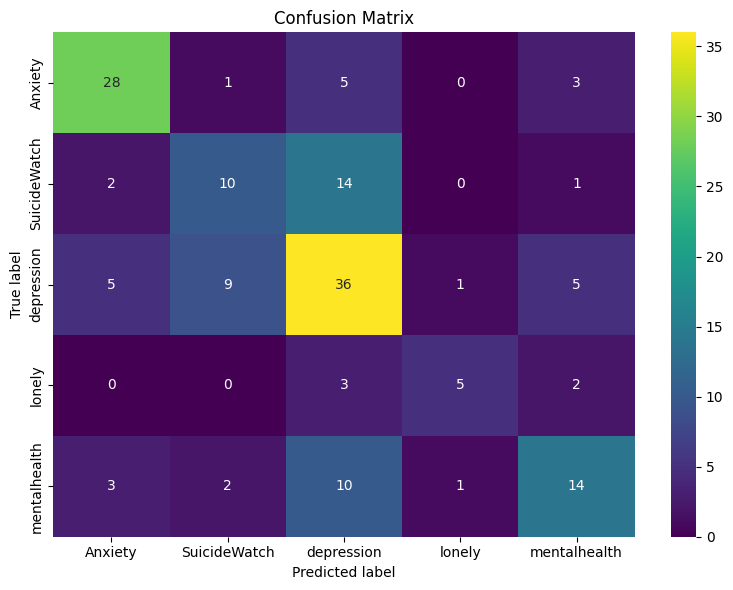

In [25]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

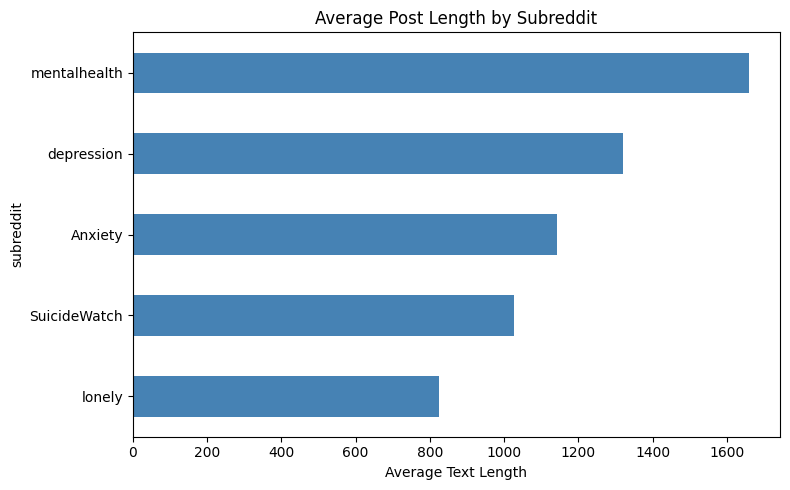


Most common words in Anxiety:
[('i', 2497), ('and', 1341), ('to', 1240), ('my', 985), ('a', 899), ('the', 858), ('it', 596), ('of', 581), ('me', 498), ('that', 495)]

Most common words in depression:
[('i', 4690), ('and', 2425), ('to', 2409), ('my', 1872), ('the', 1507), ('a', 1468), ('me', 1144), ('of', 1091), ('that', 864), ('it', 856)]

Most common words in mentalhealth:
[('i', 3050), ('to', 1634), ('and', 1521), ('my', 1119), ('the', 1110), ('a', 954), ('of', 733), ('me', 678), ('it', 658), ('that', 612)]

Most common words in SuicideWatch:
[('i', 1770), ('to', 998), ('and', 957), ('my', 712), ('the', 632), ('a', 552), ('me', 512), ('of', 428), ('it', 331), ('was', 311)]

Most common words in lonely:
[('i', 438), ('to', 249), ('and', 248), ('the', 171), ('my', 141), ('a', 127), ('me', 123), ('of', 117), ('for', 85), ('in', 83)]


In [26]:
#--- Segment B: Textual Analysis ---

# Average post length per subreddit
data['text_length'] = data['text'].apply(len)
avg_lengths = data.groupby('subreddit')['text_length'].mean().sort_values()

plt.figure(figsize=(8, 5))
avg_lengths.plot(kind='barh', color='steelblue')
plt.xlabel("Average Text Length")
plt.title("Average Post Length by Subreddit")
plt.tight_layout()
plt.show()

# Most common words per class (very basic)
from collections import Counter
for subreddit in data['subreddit'].unique():
    words = ' '.join(data[data['subreddit'] == subreddit]['text']).split()
    common = Counter(words).most_common(10)
    print(f"\nMost common words in {subreddit}:")
    print(common)




In [27]:
#--- Segment C: Text Quality Check (Optional but Insightful) ---
# Check for duplicates
print("Duplicate posts:", data.duplicated('text').sum())

# Check for class imbalance
print("Class balance:\n", data['subreddit'].value_counts(normalize=True))


Duplicate posts: 2
Class balance:
 subreddit
depression      0.34625
Anxiety         0.23375
mentalhealth    0.18875
SuicideWatch    0.17125
lonely          0.06000
Name: proportion, dtype: float64


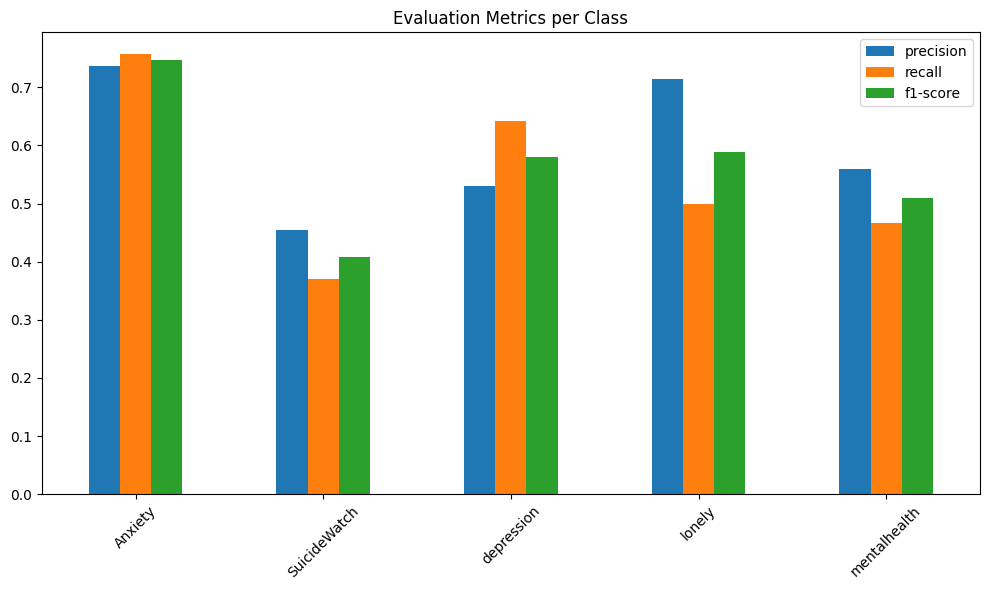

In [28]:
#--- Segment D: Additional Evaluation Metrics ---
# Visualize precision, recall, f1 per class
report_df.iloc[:-3, :][['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title("Evaluation Metrics per Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
